In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

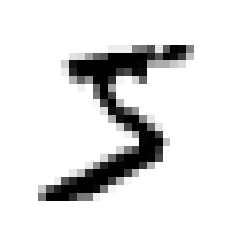

In [80]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# Corresponding labelfor above digit
y[0]

In [ ]:
import numpy as np
# y label is a string, ML algorithms expect numbers
# Converting into an integer
y = y.astype(np.uint8)

In [ ]:
# MNIST dataset is already split into training set & testing set
# This is training set is already shuffled for us, which guarantees that all cross-validation folds will be similar.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Moreover, some learning algorithms are sensitive to the order of the training instances, and then perform poorly if they get many similar instances in a row. But shuffling may be a bad idea in some contexts - If we are dealing with time series data (stock market prices or weather predictions)

# Training a Binary Classifier

In [ ]:
# Binary classifier - '5 detector'
# capable of distinguishing between two classes -> '5' or 'not 5'
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
# Classifier -> Stochastic Gradient Descent(SGD) classifier
# Suite for handling very large datasets efficiently.
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier relies on randomness during training. If we want reproducible results, we need to set the random_state parameter

In [ ]:
sgd_clf.predict([some_digit])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [ ]:
# Implementing cross validation by hand instead of Scikit-Learn's cross_val_score() function
# This gives us more control!

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

In [ ]:
# Using cross_val_score() function
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Abobe gives us 95% accuracy!, is it right ???

In [ ]:
# Dumb classifier -> classify every digit as 'not 5'
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

This has a 90% accuracy! , This is due to only 10% of the images are 5s. Hence if the model guess that an image is not 5, it will be right about 90% of the time.

**Hence accuracy is generally not a good performance measure for classifiers, specially when we have skewed datasets (*some classes are much more frequent than others* )**

### Confusion Matrix

General idea is to count the number of times instances of class A are classified as class B.

In [65]:
# To compute confusion matrix, first need to have a set of predictions which can be compared to actual targets
from sklearn.model_selection import cross_val_predict

# this function first performs K-Fold cross-validation
# then returns the predicitons made on each test fold, instead of evaluations scores
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [66]:
# Now calculate the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- *53,892 are correctly classified as 'not-5'* -> **True Negatives**
- *687 are wrongly classified as '5s'* -> **False Positives**
- *1891 are wrongly classified as 'not-5'* -> **Fasle Negative**
- *3530 are correctly classified as '5s'* -> **True Positive**

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have non-zero values only on its main diagonal.

In [67]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfections
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Concise metrics are somewhat important!

- **Precision** -> the accuracy of the positive predictions
- precision = TP / TP + FP

- **Recall** -> sensitivity or true positive rate, the ratio of positive instances that are correctly detected by the classifier

- recall = TP / TP + FN

In [72]:
# Built-in methods in Scikit-Learn
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.8370879772350012

When the model claims an image represents a 5, it is correct 83.7% of the time.

In [73]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

The model only detects 65.12% of the 5s

It is often good to combine precision and recall into a single metric called **F1 score**, which can be used to compare two classifiers. 

F1 score is *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weights to low values. As a result, **the classifier will only get a high F1 score if both precision and recall are high**.

F1 =  2 * (precision x recall) / (precision + recall)

In [74]:
# computing F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

In [77]:
# Decision Score -> based on a threshold
# If the score > threshold -> instance is assigned to positive class
# Otherwise negative class

# Returns score for each instance
y_scores = sgd_clf.decision_function([some_digit])
y_scores

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [78]:
# Let's raise the threshold value
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. This image contains a 5, and classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000. **How do we decide the threshold?**

In [85]:
# Using cross_val_predict() to get the scores of all instances in the training set
# But specifying to return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

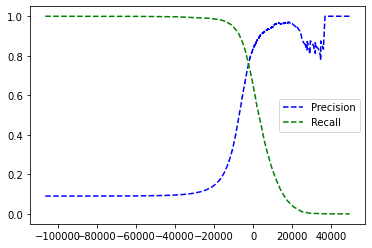

In [86]:
# With these scores, use precision_recall_curve() to compute precision and recall for all possible thresholds

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

The precision curve is bumpier than recall curve, because the precision may sometimes go down when we raise the threshold.

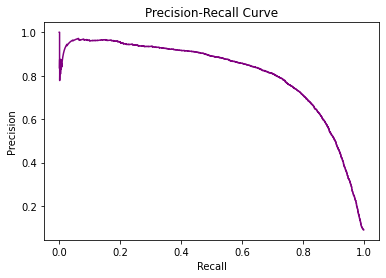

In [97]:
# Another method -> plotting precsion directly against recall
# Precision vs recall curve

def plot_precision_vs_recall_curve(precisions, recalls):
    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recalls, precisions, color='purple')
    
    # add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    
    # display plt
    plt.show()
    
plot_precision_vs_recall_curve(precisions, recalls)

### ROC Curve

Roc curve plots the true positive rate(recall) against flase postive rate(FPR).

**FPR = 1 - TNR**

TNR is also called **specificity**. Hence, the ROC curve plots **sensitivity**(recall) vs 1 - specificity.

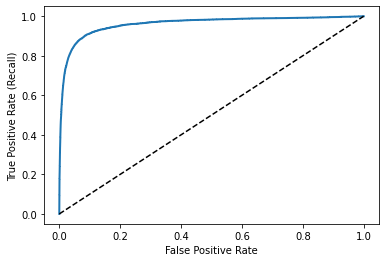

In [94]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')

plot_roc_curve(fpr, tpr)
plt.show()

There is a trade-off- the higher the recall(TPR), the more flase positives(FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier. So a good classifier stays as far away from that line as possible

One way to compare classifiers is to measure the **area under the curve (AUC)**. A perfect classifier will have a ROC AUC = 1, whereas a puerly random classifier will have ROC AUC = 0.5.

In [95]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- Prefer PR curve ->  1. whenever positive class is rare or when we care more about false positives than false negatives.

- Otherwise, ROC curve

In [98]:
# Train a RandomForestClassifier and compare its ROC curve and ROC AOC score to those of the SGDClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

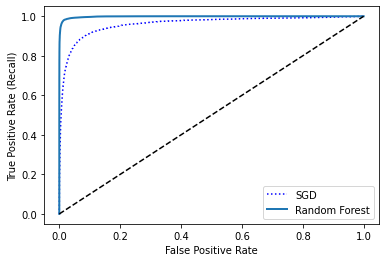

In [106]:
# Let's use the positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

# Plot the ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

RandomForestClassifier's ROC curve looks much better than SGDClassifier's - it comes much closer to the top-left corner.
As a result, its ROC AUC score is also significantly better

In [107]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called *multinomial classifiers*) **can distinguish between more than two classes.**

Some algorithms (SGD classifiers, Random Forest classifiers, Naive Bayes classifiers) are capable of handling multiple classes natively.

Others (Logisitic Regression, SVM) are strickly binary classifiers. But there are techniques available to get around it.

### One-versus-the-rest (OvR) strategy -> one-versus-all

Train **n binary classifiers** to classify **n classes**.

Then when we want to classify an instance (data point), get the decision score from each classifier for that instance and select the class whose classifier outputs the highest score.

### One-versus-One Strategy (OvO)

Train a **binary classifier** for every **pair of classes**
- If there are n classes -> then **N' = n * (n - 1) / 2** classifiers are needed.

when we want to classify an instance (data point), we have to run the instance through N' classifiers and see which class wins the most duels.

The main advantage of of OvO is that each classifier *only needs to be trained on the part of the training set for the two classes that it must distinguish.*

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set. For these algorithms OvO is preferred because it is faster to
train many classifiers on small training sets than to train few classifiers on large train‐
ing sets. For most binary classification algorithms, however, OvR is preferred.

In [108]:
# Scikit-Learn automatically chooses appropriate algorithm for multi-class classification

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

SVC model trains on the original training set using original target classes from 0 to 9 (y_train), instead of the 5 versus the rest target classes (y_train_5). Under the hood, Scikit-Learn used the OvO strategy.

- It trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

In [109]:
# decision_function() method returns 10 scores per instance
# that's one score per class.
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [114]:
# The highest score is the one corresponding to class 5
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [115]:
# We can create custom OvO or OvR
# creates a multiclass classifier using the OvR strat‐
egy, based on an SVC
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [151]:
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


In [152]:
# SGD classifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time, there isn't a OvO or OvR strategy is run, because SGD classifiers can directly classfiy instances into multiple classes.

In [153]:
# Using decision_function() to get score value per class
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [154]:
# Evaluating the model
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# Multilabel Classification

In some cases, classifier may output multiple classes for each instance.

In [159]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # digits larger than (7, 8, 9)
y_train_odd = (y_train % 2 == 1) # odd digits
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [160]:
knn_clf.predict([some_digit])

array([[False,  True]])

The model's prediction is correct, the digit 5 is indeed not large (False) and odd(True)

In [162]:
# Evaluating multilabel classifier
# Depends on the project

# Once approach is to measure F1 score for each individual label,
# then compute the average F1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important. Some cases we may need to give more weights to some labels. In that case, one simple option is to give each label a weight equal to its *support* (#instances with that target label).

- average(weighted)

# Multiout Classification

It is simply a generalization of multilabel classification where each label can be multiclass (it can have more than two possible values)

In [163]:
# System - that removes noise from images
# Input - a noisy digit image
# Output - a clean digit image
# >> represents as an array of pixel intensities

# Here classifier output is multilabel 
# >> one label per pixel, each label can have multiple values (0 - 255)
# >> hence, a mutlioutput classification system

# Create test set, train test by adding noise to their pixel intensities
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [172]:
# Train the classifier
knn_clf.fit(X_train_mod, y_train_mod)

def plot_digit(clean_digit):
    clean_digit_image = clean_digit.reshape(28, 28)
    plt.imshow(clean_digit_image, cmap="binary")
    plt.axis("off")
    plt.show()

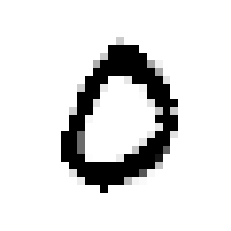

In [178]:
clean_digit = knn_clf.predict([X_test_mod.iloc[3]])
plot_digit(clean_digit)

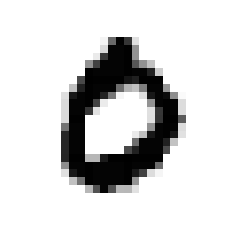

In [181]:
plot_digit(y_test_mod.iloc[3].values)

Looks close to the target!